# ROF global monthly, annual, seasonal flows analysis <a id='top'></a>

Use the following datasets

1. reach-D19 gauge link ascii
2. D19 flow site geopackage
3. D19 discharge netCDF
4. history netCD including river discharge

[1. Setupt](#setup)

[2. Loading data](#load_data)

- Read monthly history files from archive. 
- Reference data: monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. Large 24 river analysis](#24_large_rivers)

- Plotting time seriese (annual, seasonal cycle).
- if D19 referece data is available, scatter plots at Large 24 selected rivers against D19 referece data

[4. Large 50 rivers analysis](#50_large_rivers)

- Annual flow summary table at large 50 selected rivers.
- if D19 referece data is available, Scatter plot of annual flow against D19 reference data.

[5. 922 rivers analysis](#922_rivers)

- run only if reference flow is available
- error statistics (%bias, rmse, correlation) at all 922 river sites.
- plot error statistic on the global map
- plot boxplots including case(s) for each error metric

In [1]:
%matplotlib inline

import os, sys
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scripts.colors as colors
import scripts.metrics as metric
from scripts.utility import load_yaml
from scripts.utility import no_time_variable

rivers_50m = cfeature.NaturalEarthFeature("physical", "rivers_lake_centerlines", "50m")
land = cfeature.LAND

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.11.4
xarray 2025.6.1
pandas 2.3.3
geopandas 1.1.1


ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/tking/conda-envs/cupid-analysis/share/proj failed


-------------------------
## 1. Setup <a id='setup'></a>

In [2]:
# Parameter Defaults
# parameters are set in CUPiD's config.yml file
# when running interactively, manually set the parameters below

# global parameters
CESM_output_dir = ""  # e.g., "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
case_name = None  # case name: e.g., "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = None  # base case name: e.g., "b.e23_alpha17f.BLT1850.ne30_t232.092"
base_case_output_dir = None
start_date = ""  # simulation starting date: e.g., "0001-01-01"
end_date = ""  # simulation ending date: "0100-01-01"
base_start_date = ""  # base simulation starting date: "0001-01-01"
base_end_date = ""  # base simulation ending date: "0100-01-01"
serial = True  # use dask LocalCluster
lc_kwargs = {}

# rof parameters
hist_str = ""  # Used for hist file tag
analysis_name = ""  # Used for Figure png names
climo_nyears = 10  # number of years to compute the climatology
grid_name = "f09_f09_mosart"  # ROF grid name used in case
base_grid_name = (
    grid_name  # spcify ROF grid name for base_case in config.yml if different than case
)
figureSave = False

In [3]:
# Parameters
case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.243"
base_case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234"
case_nickname = "BLT1850_243"
base_case_nickname = "BLT1850_234"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0033-01-01"
climo_start_year = 13
climo_end_year = 33
base_start_date = "0001-01-01"
base_end_date = "0081-01-01"
base_climo_start_year = 61
base_climo_end_year = 81
obs_data_dir = (
    "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data"
)
ts_dir = None
lc_kwargs = {"threads_per_worker": 1}
serial = False
hist_str = "h0a"
analysis_name = ""
grid_name = "f09_f09_mosart"
climo_nyears = 10
figureSave = False
subset_kwargs = {}
product = "/glade/work/tking/cupid_project/other_cupids/234v243/CUPiD/examples/key_metrics/computed_notebooks//rof/global_discharge_gauge_compare_obs.ipynb"


In [4]:
if base_case_output_dir is None:
    base_case_output_dir = CESM_output_dir

In [5]:
# ROF additional setup
setup = load_yaml("./setup/setup.yaml")

ancillary_dir = setup[
    "ancillary_dir"
]  # ancillary directory including ROF domain, river network data etc.
ref_flow_dir = setup["ref_flow_dir"]  # including observed or reference flow data
case_meta = setup["case_meta"]  # Case metadata
reach_gpkg = setup["reach_gpkg"]  # river reach geopackage meta

if analysis_name:
    analysis_name = case_name
if base_grid_name:
    base_grid_name = grid_name

case_dic = {
    case_name: {
        "grid": grid_name,
        "sim_period": slice(f"{start_date}", f"{end_date}"),
        "climo_nyrs": min(climo_nyears, int(end_date[:4]) - int(start_date[:4]) + 1),
        "output_dir": CESM_output_dir,
    }
}
if base_case_name is not None:
    case_dic[base_case_name] = {
        "grid": grid_name,
        "sim_period": slice(f"{base_start_date}", f"{base_end_date}"),
        "climo_nyrs": min(
            climo_nyears, int(base_end_date[:4]) - int(base_start_date[:4]) + 1
        ),
        "output_dir": base_case_output_dir,
    }

### Dasks

In [6]:
# When running interactively, cupid_run should be set to False
cupid_run = True

client = None
if cupid_run:
    # Spin up cluster (if running in parallel)
    if not serial:
        from dask.distributed import Client, LocalCluster

        cluster = LocalCluster(**lc_kwargs)
        client = Client(cluster)
else:
    if not serial:
        from dask.distributed import Client
        from dask_jobqueue import PBSCluster

        cluster = PBSCluster(
            cores=1,
            processes=1,
            memory="50GB",
            queue="casper",
            walltime="01:00:00",
        )
        cluster.scale(jobs=10)
        client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38391,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33375,Total threads: 1
Dashboard: http://127.0.0.1:40643/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:46553,


## 2. Loading data <a id='load_data'></a>

### 2.1. Monthly/annual flow netCDFs
- month_data (xr dataset) - read from archive
- year_data (xr dataset) - computed from monthly
- seas_data (xr dataset) - computed from monthly

In [7]:
%%time

reachID = {}
month_data = {}
year_data = {}
seas_data = {}
for case, meta in case_dic.items():
    in_dire = os.path.join(meta["output_dir"], case, "rof/hist")
    model = case_meta[meta["grid"]]["model"]
    domain = case_meta[meta["grid"]]["domain_nc"]
    var_list = case_meta[meta["grid"]]["vars_read"]

    def preprocess(ds):
        return ds[var_list]

    year_list = [
        "{:04d}".format(yr)
        for yr in np.arange(
            int(meta["sim_period"].start[0:4]), int(meta["sim_period"].stop[0:4]) + 1
        )
    ]

    nc_list = []
    for nc_path in sorted(glob.glob(f"{in_dire}/{case}.{model}.{hist_str}.????-*.nc")):
        for yr in year_list:
            if yr in os.path.basename(nc_path):
                nc_list.append(nc_path)

    # load data
    ds = xr.open_mfdataset(
        nc_list,
        data_vars="minimal",
        parallel=True,
        preprocess=preprocess,
    ).sel(time=meta["sim_period"])

    # monthly
    month_data[case] = ds.isel(time=slice(-meta["climo_nyrs"] * 12, None)).load()
    # annual
    year_data[case] = (
        ds.isel(time=slice(-meta["climo_nyrs"] * 12, None))
        .resample(time="YS")
        .mean(dim="time")
        .load()
    )
    # seasonal (compute here instead of reading for conisistent analysis period)
    seas_data[case] = (
        ds.isel(time=slice(-meta["climo_nyrs"] * 12, None))
        .groupby("time.month")
        .mean("time")
        .load()
    )
    vars_no_time = no_time_variable(month_data[case])
    if vars_no_time:
        seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(
            month=0, drop=True
        )
    mon_time = month_data[case].time.values
    if domain == "None":
        reachID[case] = month_data[case]["reachID"].values
    else:
        reachID[case] = xr.open_dataset(f"{ancillary_dir}/{domain}")["reachID"].values
    print(f"Finished loading {case}")

Finished loading b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.243


Finished loading b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234
CPU times: user 10.5 s, sys: 1.26 s, total: 11.7 s
Wall time: 22.8 s


### 2.2 Large river ID and name ascii
- big_river_50: dictionary {_site_id_:_river name_}
- big_river_24: dictionary {_site_id_:_river name_}

In [8]:
df = pd.read_csv("./setup/large_river_50.txt", index_col="river_name")
big_river_50 = {key: values["site_id"] for key, values in df.iterrows()}
big_river_24 = {
    key: values["site_id"] for ix, (key, values) in enumerate(df.iterrows()) if ix < 24
}  # The first 24 is used for plots

### 2.3. reach-D19 gauge link csv
- gauge_reach_lnk (dataframe)

In [9]:
gauge_reach_lnk = {}
for case, meta in case_dic.items():
    gauge_reach_lnk[case] = pd.read_csv(
        "%s/D09/D09_925.%s.asc" % (ref_flow_dir, case_meta[meta["grid"]]["network"])
    )

### 2.4 D19 flow site shapefile
- gauge_shp (dataframe)

In [10]:
%%time

gauge_shp = gpd.read_file(
    os.path.join(ref_flow_dir, "D09", "geospatial", "D09_925.gpkg")
)
gauge_shp = gauge_shp[gauge_shp["id"] != 9999999]

CPU times: user 19.3 ms, sys: 293 μs, total: 19.6 ms
Wall time: 18.7 ms


### 2.5 D19 discharge data
- ds_q_obs_mon (xr datasets)
- ds_q_obs_yr (xr datasets)
- dr_q_obs_seasonal (xr datasets)

In [11]:
%%time

# read monthly data
ds_q = xr.open_dataset(
    "%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc" % (ref_flow_dir),
    decode_times=False,
)
ds_q["time"] = xr.cftime_range(
    start="1900-01-01", end="2018-12-01", freq="MS", calendar="standard"
)

# monthly - if time_period is outside observation period, use the entire obs period
obs_available = True
if ds_q["time"].sel(time=slice(str(mon_time[0]), str(mon_time[-1]))).values.size == 0:
    obs_available = False
    ds_q_obs_mon = ds_q["FLOW"]
else:
    ds_q_obs_mon = ds_q["FLOW"].sel(time=slice(str(mon_time[0]), str(mon_time[-1])))
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="YE").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = ds_q_obs_mon.groupby("time.month").mean("time")
# annual mean, max, and min flow during time_period
ds_q_obs_yr_min = ds_q_obs_yr.min("time")
ds_q_obs_yr_max = ds_q_obs_yr.max("time")
ds_q_obs_yr_mean = ds_q_obs_yr.mean("time")

CPU times: user 121 ms, sys: 7.81 ms, total: 129 ms
Wall time: 134 ms


<timed exec>:6: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.


### 2.6 Get indices in observation and simulation for gauge name (processing)
- gauge_plot (dictionary)

In [12]:
gauge_plot = {}
for gname, site_id in big_river_50.items():
    gauge_plot[gname] = {}
    for case in case_dic.keys():
        gauge_ix = [
            i for i, gid in enumerate(ds_q.id.values) if gid == site_id
        ]  # go through obs Dataset and get index matching to river (gauge) name
        gauge_id = ds_q.id.values[gauge_ix][0]  ## guage ID
        seg_id = (
            gauge_reach_lnk[case]
            .loc[gauge_reach_lnk[case]["gauge_id"] == gauge_id]["route_id"]
            .values
        )  # matching reach ID in river network
        seg_ix = np.argwhere(
            reachID[case] == seg_id
        )  # matching reach index in river network
        if len(seg_ix) == 0:
            seg_ix = -999
        else:
            seg_ix = seg_ix[0]
        gauge_plot[gname][case] = [gauge_ix, seg_ix, seg_id]

------
## 3. Analysis for 24 large rivers <a id='24_large_rivers'></a>

### 3.1 Annual flow series

CPU times: user 528 ms, sys: 1.68 ms, total: 530 ms
Wall time: 524 ms


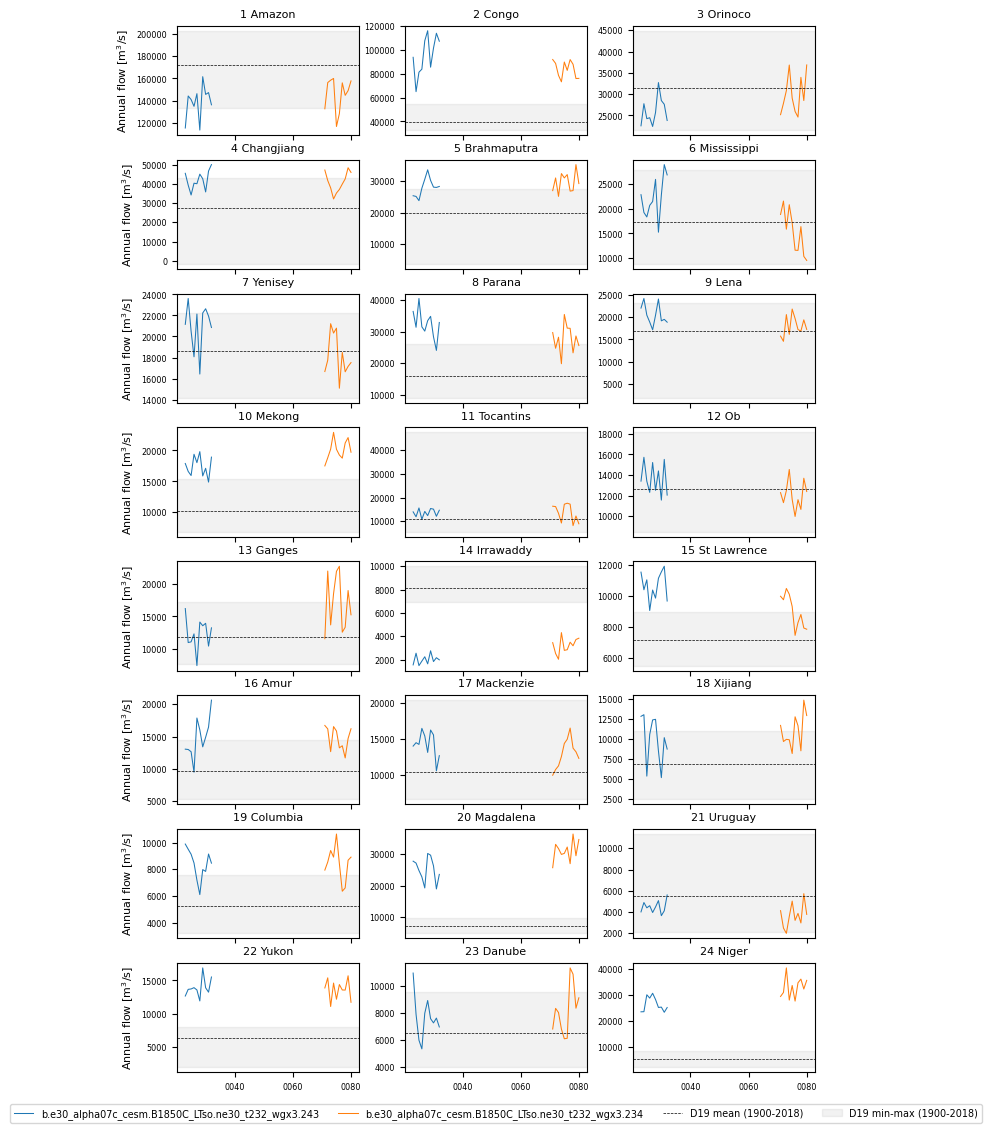

In [13]:
%%time

fig, axes = plt.subplots(8, 3, figsize=(7.25, 11.5))
plt.subplots_adjust(
    top=0.975, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
)  # create some space below the plots by increasing the bottom-value

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    for case, meta in case_dic.items():
        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[meta["grid"]]["flow_name"]

        if len(net_idx) == 1:
            year_data[case][q_name][:, net_idx].plot(
                ax=axes[row, col], linestyle="-", lw=0.75, label=case
            )
        elif len(net_idx) == 2:  # means 2d grid
            year_data[case][q_name][:, net_idx[0], net_idx[1]].plot(
                ax=axes[row, col], linestyle="-", lw=0.75, label=case
            )
    if obs_available:
        ds_q_obs_yr.loc[:, gaug_idx].plot(
            ax=axes[row, col],
            linestyle="None",
            marker="o",
            markersize=3,
            c="k",
            label="D19",
        )
    else:
        qob_mean = ds_q_obs_yr_mean.loc[gaug_idx]
        qob_max = ds_q_obs_yr_max.loc[gaug_idx]
        qob_min = ds_q_obs_yr_min.loc[gaug_idx]
        axes[row, col].axhline(
            y=qob_mean, color="k", linestyle="--", lw=0.5, label="D19 mean (1900-2018)"
        )
        axes[row, col].axhspan(
            qob_min[0],
            qob_max[0],
            color="gray",
            alpha=0.1,
            label="D19 min-max (1900-2018)",
        )

    axes[row, col].set_title("%d %s" % (ix + 1, river_name), fontsize=8)

    axes[row, col].set_xlabel("")
    if row < 7:
        axes[row, col].set_xticklabels("")
    if col == 0:
        axes[row, col].set_ylabel("Annual flow [m$^3$/s]", fontsize=8)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

# Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.125, -0.35, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig1_big_river_annual_{analysis_name}.png", dpi=200)

### 3.2. Annual cycle at monthly step

CPU times: user 165 ms, sys: 0 ns, total: 165 ms
Wall time: 162 ms


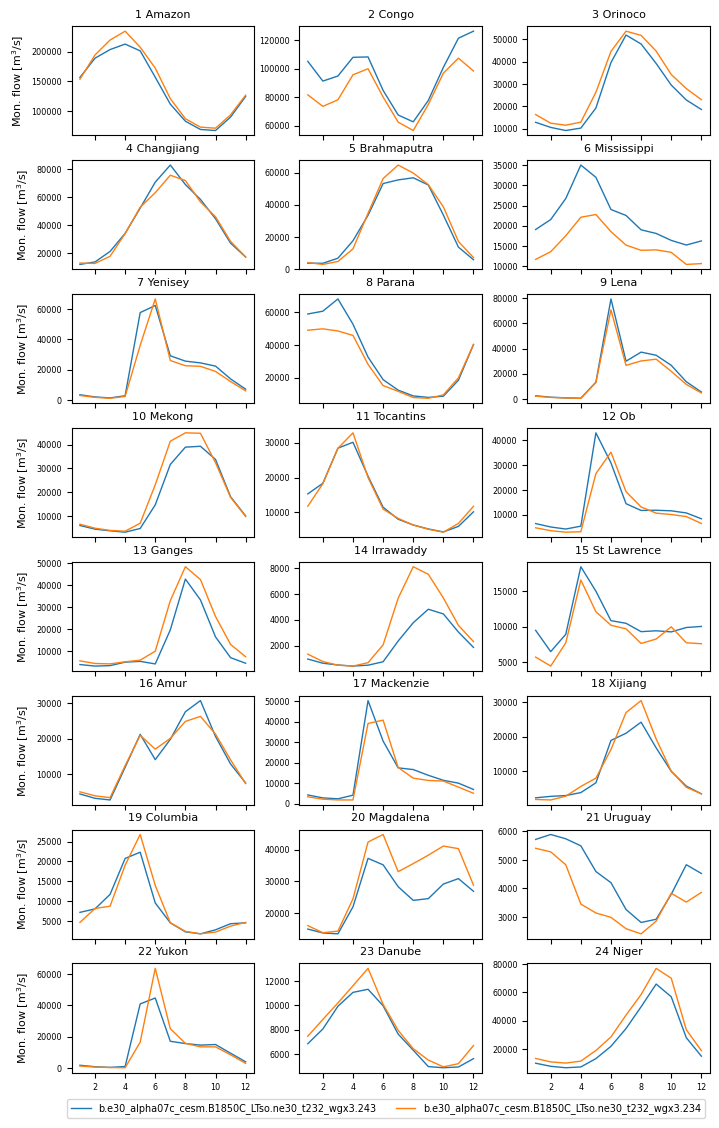

In [14]:
%%time

fig, axes = plt.subplots(8, 3, figsize=(7.25, 11.5))
plt.subplots_adjust(
    top=0.975, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
)  # create some space below the plots by increasing the bottom-value

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    for case, meta in case_dic.items():
        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[meta["grid"]]["flow_name"]

        if len(net_idx) == 1:  # means vector
            seas_data[case][q_name][:, net_idx].plot(
                ax=axes[row, col], linestyle="-", lw=0.75, label=case
            )
        elif len(net_idx) == 2:  # means 2d grid
            seas_data[case][q_name][:, net_idx[0], net_idx[1]].plot(
                ax=axes[row, col], linestyle="-", lw=1.0, label=case
            )

    if obs_available:
        dr_q_obs_seasonal.loc[:, gaug_idx].plot(
            ax=axes[row, col],
            linestyle=":",
            lw=0.5,
            marker="o",
            markersize=2,
            c="k",
            label="D19",
        )

    axes[row, col].set_title("%d %s" % (ix + 1, river_name), fontsize=8)
    axes[row, col].set_xlabel("")
    if row < 7:
        axes[row, col].set_xticklabels("")
    if col == 0:
        axes[row, col].set_ylabel("Mon. flow [m$^3$/s]", fontsize=8)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

# Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.10, -0.30, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig2_big_river_season_{analysis_name}.png", dpi=200)

### 3.3. scatter plots of monthly flow - obs vs sim

In [15]:
%%time

if obs_available:
    # Monthly flow scatter plot
    fig, axes = plt.subplots(8, 3, figsize=(7.50, 15.00))
    plt.subplots_adjust(
        top=0.995, bottom=0.075, right=0.995, left=0.1, wspace=0.25, hspace=0.25
    )

    for ix, river_name in enumerate(big_river_24.keys()):
        row = ix // 3
        col = ix % 3
        axes[row, col].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

        for jx, (case, meta) in enumerate(case_dic.items()):

            net_idx = gauge_plot[river_name][case][1]
            gaug_idx = gauge_plot[river_name][case][0]

            q_name = case_meta[meta["grid"]]["flow_name"]

            if len(net_idx) == 1:  # means vector
                ds_sim = month_data[case][q_name][:, net_idx]
            elif len(net_idx) == 2:  # means 2d grid
                ds_sim = month_data[case][q_name][:, net_idx[0], net_idx[1]].squeeze()

            ds_obs = ds_q_obs_mon.sel(time=meta["time_period"]).loc[:, gaug_idx]

            axes[row, col].plot(
                ds_obs, ds_sim, "o", label=case, markersize=4.0, alpha=0.4
            )
            if jx == 0:
                max_val = np.max(ds_obs)
                min_val = np.min(ds_obs)
            else:
                max_val = np.max([np.max(ds_sim), max_val])
                min_val = np.min([np.min(ds_sim), min_val])

        axes[row, col].plot(
            [min_val * 0.98, max_val * 1.02],
            [min_val * 0.98, max_val * 1.02],
            ":k",
            linewidth=0.5,
        )

        axes[row, col].annotate(
            "%d %s" % (ix + 1, river_name),
            xy=(0.05, 0.875),
            xycoords="axes fraction",
            fontsize=8,
            bbox=dict(facecolor="white", edgecolor="None", alpha=0.8),
        )
        if row == 7 and col == 1:
            axes[row, col].set_xlabel(
                "Monthly reference discharge [m$^3$/s]", fontsize=9
            )
        else:
            axes[row, col].set_xlabel("")

        if col == 0 and row == 5:
            axes[row, col].set_ylabel(
                "Monthly simulated discharge [m$^3$/s]", fontsize=10
            )
        else:
            axes[row, col].set_ylabel("")
        axes[row, col].tick_params("both", labelsize="xx-small")

    axes.flatten()[-2].legend(
        loc="upper center",
        bbox_to_anchor=(0.10, -0.40, 0.75, 0.1),
        ncol=5,
        fontsize="x-small",
    )

    if figureSave:
        plt.savefig(f"./NB1_Fig3_big_river_month_scatter_{analysis_name}.png", dpi=200)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 6.2 μs


### 3.4. scatter plots of annual flow

In [16]:
%%time
if obs_available:
    # annual flow scatter plot
    fig, axes = plt.subplots(8, 3, figsize=(7.50, 15.00))
    plt.subplots_adjust(
        top=0.995, bottom=0.075, right=0.995, left=0.1, wspace=0.25, hspace=0.25
    )

    for ix, river_name in enumerate(big_river_24.keys()):
        row = ix // 3
        col = ix % 3
        axes[row, col].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

        for jx, (case, meta) in enumerate(case_dic.items()):
            net_idx = gauge_plot[river_name][case][1]
            gaug_idx = gauge_plot[river_name][case][0]

            q_name = case_meta[meta["grid"]]["flow_name"]

            if len(net_idx) == 1:  # means vector
                ds_sim = year_data[case][q_name][:, net_idx]
            elif len(net_idx) == 2:  # means 2d grid
                ds_sim = year_data[case][q_name][:, net_idx[0], net_idx[1]]

            ds_obs = ds_q_obs_yr.sel(time=meta["time_period"]).loc[:, gaug_idx]

            axes[row, col].plot(
                ds_obs, ds_sim, "o", label=case, markersize=4.0, alpha=0.4
            )
            if jx == 0:
                max_val = np.max(ds_obs)
                min_val = np.min(ds_obs)
            else:
                max_val = np.max([np.max(ds_sim), max_val])
                min_val = np.min([np.min(ds_sim), min_val])

        axes[row, col].plot(
            [min_val * 0.98, max_val * 1.02],
            [min_val * 0.98, max_val * 1.02],
            ":k",
            linewidth=0.5,
        )

        axes[row, col].annotate(
            "%d %s" % (ix + 1, river_name),
            xy=(0.05, 0.875),
            xycoords="axes fraction",
            fontsize=8,
            bbox=dict(facecolor="white", edgecolor="None", alpha=0.8),
        )
        if row == 7 and col == 1:
            axes[row, col].set_xlabel(
                "Monthly reference discharge [m$^3$/s]", fontsize=9
            )
        else:
            axes[row, col].set_xlabel("")

        if col == 0 and row == 5:
            axes[row, col].set_ylabel(
                "Monthly simulated discharge [m$^3$/s]", fontsize=10
            )
        else:
            axes[row, col].set_ylabel("")
        axes[row, col].tick_params("both", labelsize="xx-small")

    axes.flatten()[-2].legend(
        loc="upper center",
        bbox_to_anchor=(0.10, -0.40, 0.75, 0.1),
        ncol=5,
        fontsize="x-small",
    )

    if figureSave:
        plt.savefig(f"./NB1_Fig4_big_river_annual_scatter_{analysis_name}.png", dpi=200)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


## 4. Anaysis for Large 50 rivers <a id='50_large_rivers'></a>

### 4.1 Summary tables

In [17]:
%%time

with open(f"large50rivers_{analysis_name}.txt", "w") as f:
    # some meta
    f.write("# obs: Dai et al.(2019)\n")
    f.write("# vol: km^3/yr\n")
    f.write("# area: km^2\n")

    # headers
    f.write("No,          river_name,")
    f.write("{0: >15}_vol,".format("obs"))
    for jx, (case, meta) in enumerate(case_dic.items()):
        f.write("{0: >15}_vol,".format(meta["grid"]))
    f.write("{0: >15}_area".format("obs"))
    for jx, (case, meta) in enumerate(case_dic.items()):
        f.write(",")
        f.write("{0: >15}_area".format(meta["grid"]))
    f.write("\n")

    # data for each river
    for ix, river_name in enumerate(big_river_50.keys()):

        f.write("%02d," % (ix + 1))
        f.write("{0: >20}".format(river_name))

        for jx, (case, meta) in enumerate(case_dic.items()):
            f.write(",")
            net_idx = gauge_plot[river_name][case][1]
            gaug_idx = gauge_plot[river_name][case][0]

            q_name = case_meta[meta["grid"]]["flow_name"]

            if len(net_idx) == 1:  # means vector
                qsim = (
                    np.nanmean(year_data[case][q_name][:, net_idx].values)
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )
            elif len(net_idx) == 2:  # means 2d grid
                qsim = (
                    np.nanmean(
                        year_data[case][q_name][:, net_idx[0], net_idx[1]].values
                    )
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )

            if jx == 0:
                qobs = (
                    ds_q_obs_yr_mean.loc[gaug_idx].values[0]
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )
                f.write("{:19.1f},".format(qobs))

            f.write("{:19.1f}".format(qsim))

        for jx, (case, _) in enumerate(case_dic.items()):
            f.write(",")
            gaug_idx = gauge_plot[river_name][case][0]

            # just get gauge_id from qs_q for now
            gauge_id = ds_q["id"].loc[gaug_idx].values[0]
            network_area = gauge_reach_lnk[case][
                gauge_reach_lnk[case]["gauge_id"] == gauge_id
            ]["route_area"].values[0]

            if jx == 0:
                area = ds_q["area_stn"].loc[gaug_idx].values[0]
                f.write("{:20.0f},".format(area))

            f.write("{:20.0f}".format(network_area))

        f.write("\n")

CPU times: user 99.3 ms, sys: 186 μs, total: 99.5 ms
Wall time: 91.8 ms


### 4.2. scatter plot of annual mean flow

In [18]:
if obs_available:

    df_yr_vol = pd.read_csv(
        f"./large50rivers_{analysis_name}.txt",
        skiprows=3,
        index_col=["No"],
        skipinitialspace=True,
    )

    fig, axes = plt.subplots(1, figsize=(5.50, 5.50))
    regressor = LinearRegression()
    bias_text = ""

    for jx, (case, meta) in enumerate(case_dic.items()):
        # compute linear regression
        df_reg = df_yr_vol[["obs_vol", f"{meta['grid']}_vol"]].dropna()
        regressor.fit(df_reg[["obs_vol"]], df_reg[f"{meta['grid']}_vol"])
        y_pred = regressor.predict(df_reg[["obs_vol"]])

        # compute bias over 50 sites
        diff = (df_yr_vol[f"{meta['grid']}_vol"] - df_yr_vol["obs_vol"]).mean(
            axis=0, skipna=True
        )

        df_yr_vol.plot(
            ax=axes,
            kind="scatter",
            x="obs_vol",
            y=f"{meta['grid']}_vol",
            s=30,
            alpha=0.6,
            label=meta["grid"],
        )
        # plt.plot(df_reg['obs_vol'], y_pred, color=color)
        bias_text = bias_text + f"\n{meta['grid']}: {diff:.1f} "

    plt.text(
        0.65, 0.30, "bias [km3/yr]", transform=axes.transAxes, verticalalignment="top"
    )
    plt.text(
        0.65, 0.30, f"{bias_text} ", transform=axes.transAxes, verticalalignment="top"
    )

    plt.axline((0, 0), slope=1, linestyle="--", color="black")
    axes.set_xscale("log")
    axes.set_yscale("log")
    axes.set_xlabel("reference flow")
    axes.set_ylabel("Simulated flow")
    axes.set_title("River Flow at stations [km^3/yr]")

    if figureSave:
        plt.savefig(
            f"./NB1_Fig5_50big_river_annual_flow_scatter_{analysis_name}.png", dpi=200
        )

------
## 5. Anaysis for all 922 sites <a id='922_rivers'></a>

### 5.1 Compute metris at all the sites (no plots nor tables)

In [19]:
%%time
if obs_available:
    # Merge gauge_reach lnk (dataframe) into gauge shapefile
    gauge_shp1 = {}
    for case, df in gauge_reach_lnk.items():
        # df = df.loc[(df['flag'] == 0)]
        df1 = df.drop(columns=["riv_name"])
        gauge_shp1[case] = pd.merge(
            gauge_shp, df1, how="inner", left_on="id", right_on="gauge_id"
        )

    # compute %bias, correlation, and RMSE at each site based on monthly
    mon_pbias = {}
    mon_corr = {}
    mon_rmse = {}

    for case, meta in case_dic.items():
        bias = np.full(len(gauge_shp1[case]), np.nan, dtype=float)
        corr = np.full(len(gauge_shp1[case]), np.nan, dtype=float)
        rmse = np.full(len(gauge_shp1[case]), np.nan, dtype=float)

        q_name = case_meta[meta["grid"]]["flow_name"]

        for ix, row in gauge_shp1[case].iterrows():
            q_obs = np.full(
                meta["climo_nyrs"] * 12, np.nan, dtype=float
            )  # dummy q_sim that will be replaced by actual data if exist
            q_sim = np.full(
                meta["climo_nyrs"] * 12, np.nan, dtype=float
            )  # dummy q_sim that will be replaced by actual data if exist

            route_id = row["route_id"]
            gauge_id = row["gauge_id"]

            gauge_ix = np.argwhere(ds_q.id.values == gauge_id)
            if len(gauge_ix) == 1:
                gauge_ix = gauge_ix[0]
                q_obs = ds_q_obs_mon[:, gauge_ix].squeeze().values

            route_ix = np.argwhere(reachID[case] == route_id)
            if (
                len(route_ix) == 1
            ):  # meaning there is flow site in network and simulation exist at this site
                route_ix = route_ix[0]
                if len(route_ix) == 1:  # means vector
                    q_sim = month_data[case][q_name][:, route_ix].squeeze().values
                elif len(route_ix) == 2:  # means 2d grid
                    q_sim = (
                        month_data[case][q_name][:, route_ix[0], route_ix[1]]
                        .squeeze()
                        .values
                    )

                # compute %bias, correlation, RMSE
                bias[ix] = metric.pbias(q_sim, q_obs)
                corr[ix] = metric.corr(q_sim, q_obs)
                rmse[ix] = metric.rmse(qsim, qobs)

        mon_pbias[case] = bias
        mon_corr[case] = corr
        mon_rmse[case] = rmse

        gauge_shp1[case][f"bias_{meta['grid']}"] = bias
        gauge_shp1[case][f"corr_{meta['grid']}"] = corr
        gauge_shp1[case][f"rmse_{meta['grid']}"] = rmse

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 10.3 μs


### 5.2. Spatial metric map 

In [20]:
%%time
if obs_available:
    # some local plot setups
    cbar_kwrgs = {
        "bias": {
            "shrink": 0.9,
            "pad": 0.02,
            "orientation": "horizontal",
            "extend": "both",
        },
        "corr": {
            "shrink": 0.9,
            "pad": 0.02,
            "orientation": "horizontal",
            "extend": "min",
        },
        "rmse": {
            "shrink": 0.9,
            "pad": 0.02,
            "orientation": "horizontal",
            "extend": "max",
        },
    }

    meta = {
        "bias": {
            "name": "%bias",
            "vmin": -100,
            "vmax": 100,
            "cm": colors.cmap_RedGrayBlue,
        },
        "corr": {"name": "correlation", "vmin": 0.2, "vmax": 1, "cm": colors.cmap_corr},
        "rmse": {"name": "RMSE", "vmin": 0, "vmax": 1000, "cm": mpl.cm.turbo},
    }

    for error_metric in ["rmse", "bias", "corr"]:
        for case, meta in case_dic.items():
            fig, ax = plt.subplots(
                1, figsize=(7.5, 4.0), subplot_kw={"projection": ccrs.PlateCarree()}
            )

            ax.add_feature(
                rivers_50m, facecolor="None", edgecolor="b", lw=0.5, alpha=0.3
            )
            ax.add_feature(land, facecolor="white", edgecolor="grey")

            gauge_shp1[case].plot(
                ax=ax,
                column=f"{error_metric}_{meta['grid']}",
                markersize=10,
                cmap=meta[error_metric]["cm"],
                vmin=meta[error_metric]["vmin"],
                vmax=meta[error_metric]["vmax"],
            )

            ax.set_title("%s %s" % (case, meta[error_metric]["name"]))

            points = ax.collections[-1]
            plt.colorbar(points, ax=ax, **cbar_kwrgs[error_metric])

            plt.tight_layout()

            if figureSave:
                plt.savefig(f"./NB1_Fig6_{error_metric}_{case}_map.png", dpi=200)

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 10 μs


### 5.4 Boxplots of Error metrics (RMSE, %bias, and correlation coefficient)
Boxplot distribution is based on metrics sampled at 922 sites.

The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). 
The whiskers extend from the edges of box to show the range of the data. 
By default, they extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval. 
Outliers are plotted as separate dots.

In [21]:
if obs_available:
    boxprops = {"linestyle": "-", "linewidth": 1.5, "color": "blue"}
    medianprops = {"linestyle": "-", "linewidth": 1.5, "color": "red"}

    for error_metric in ["rmse", "bias", "corr"]:
        column_stat = []
        gauge_shp_all_case = gauge_shp.copy(deep=True)
        for case, meta in case_dic.items():
            gauge_shp_all_case = gauge_shp_all_case.merge(
                gauge_shp1[case][["id", f"{error_metric}_{meta['grid']}"]],
                left_on="id",
                right_on="id",
            )
            column_stat.append(f"{error_metric}_{meta['grid']}")
        fig, ax = plt.subplots(1, figsize=(6.5, 4))
        gauge_shp_all_case.boxplot(
            ax=ax,
            column=column_stat,
            boxprops=boxprops,
            medianprops=medianprops,
            sym=".",
        )

        xticklabels = [label[len(error_metric) + 1 :] for label in column_stat]
        ax.set_xticklabels(xticklabels)

        if error_metric == "rmse":
            ax.set_ylim([0, 1000])
            ax.set_title("RMSE [m3/s]")
        elif error_metric == "bias":
            ax.set_ylim([-150, 250])
            ax.set_title("%bias [%]")
        elif error_metric == "corr":
            ax.set_ylim([-0.2, 1])
            ax.set_title("correlation")

        if figureSave:
            plt.savefig(f"./NB1_Fig7_{error_metric}_boxplot.png", dpi=150)

In [22]:
if client:
    client.shutdown()